# iFood image classification 

This notebook contains the code used to do preliminary analysis of the ifood-2019-fgcv6 dataset as well as some quick model fitting to see how challenging it is to model this dataset.The goal is to classify images into one of 251 food groups. The main challenges posed by the problem's creators are the fine-grained classes and noise in the data (mislabeled images, unrelated images, etc).

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import data_utils

In [1]:
# load data and labels 
X_train, y_train, labs_train = data_utils.load_train()
X_val, y_val, labs_val = data_utils.load_val()

In [5]:
# returns the dimensions of the data in the form of (rows, colums)
# each row represents a flattened 32 x 32 x 3 image vector
X_train.shape

(118475, 3072)

In [6]:
# each row in y_train is an integer between 0 and 250
# representing the class that the image belongs to 
y_train.shape

(118475,)

## Exploratory Analysis 

The provided data set contained around 118,000 training images, and around 10,000 testing and validation images.We began trying to understand this by examining how the data was distributed into each class, which yeilds the following: 


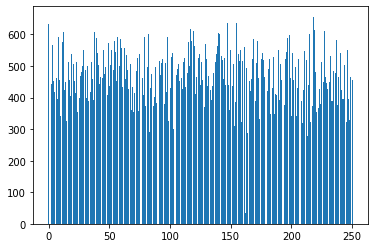

In [11]:
# finds the frequency of each label in y_train
count = np.unique(y_train, return_counts=True)
plt.bar(count[0], count[1])
plt.show()

The classes seemed to be roughly evenly distributed, but had quite a bit of variance. The smallest group had 34 pictures while the largest had 656. The mean number of pictures per class was 472. This instantly posed two concerns, that 472 images might not be enough training for each class and that classes with even fewer pictures in the data set might be harder to correctly identify.


In [14]:
# mean vector of all the training values
mean_picture = np.mean(X_train, axis=0)

In [16]:
def unroll(image_vector, min_val, max_val):
    """ convert a 2D vector into a 3D RGB vector
    scale all values in the vector to be between min_val and max_val
    """
    bias_removed = image_vector.T 
    image = bias_removed.reshape(32, 32, 3)
    image = 255.0 * (image.squeeze() - min_val) / (max_val - min_val)
    return image

(-0.5, 31.5, 31.5, -0.5)

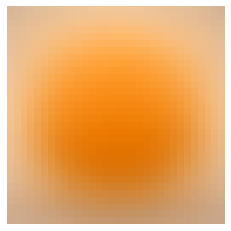

In [18]:
# find the min and max values of the image and plot the image
img_min = np.min(mean_picture)
img_max = np.max(mean_picture)
mean_img = unroll(mean_picture, img_min, img_max)
plt.imshow(mean_img.astype('uint8'))
plt.axis('off')

Most notably, the average image is surrounded by a white disk for the "plate", indicating a substantial portion of the images were top-down pictures of food on a plate.

## GDA 

We then used Scikit-learn's implementation of LDA to fit a GDA model on our dataset.This model allows us to also visualize the average image of each class as well as the covariance between different pixels

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fit a GDA model on the X_train, y_train and keep the covariance matrix 
clf = LinearDiscriminantAnalysis(store_covariance=True)
clf.fit(X_train, y_train)

# calculate the training accuracy on X_train and y_train
pred_train = clf.predict(X_train)
train_accuracy = np.sum((pred_train == y_train).astype(int))/ len(y_train)
train_accuracy

0.4500274319476683

In [87]:
# calculate the accuracy of the model on the validation data X_val and y_val
pred_val = clf.predict(X_val)
test_accuracy = np.sum((pred_val == y_val).astype(int))/ len(y_val)
test_accuracy

0.01984325496081374

In [88]:
# get the minimum and maximum values of the means of all 251 classes
minimum = np.min(clf.means_)
maximum = np.max(clf.means_)

# first n class means as images
n = 10

images = []
for i in range(n):
    images.append(unroll(clf.means_[i], minimum, maximum))

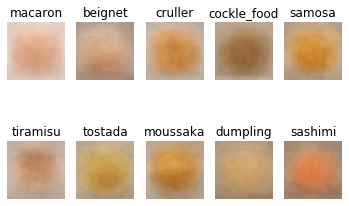

In [89]:
# the names of the first 10 classes
classes = ["macaron", "beignet", "cruller", 
           "cockle_food", "samosa", "tiramisu", "tostada", 
           "moussaka", "dumpling", "sashimi"]
for i in range(10):
    # plot the average picture for each class 
    plt.subplot(2, 5, i + 1) # use 2 x 5 grid layout 
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

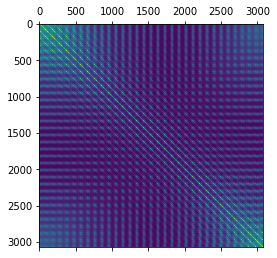

In [90]:
# visualize the covariance matrix of the model 
plt.matshow(clf.covariance_)
plt.show()

## Dimension Reduction

Our next step in making sense of the data was to use dimension reduction to visualize the data. We used principal component analysis (PCA) to reduce the number of dimensions to 2. We then assigned each class a random color and created the following visualization:

In [91]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# use PCA to map X_train to 2 components
X_train_normalized = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_normalized)

# save the results onto a dataframe principalDf
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf["label"] = y_train
principalDf.head()

,principal component 1,principal component 2,label
0,-37.956471,17.054661,94
1,-9.896801,21.212025,94
2,-59.068533,-10.255345,94
3,-8.467775,5.957215,94
4,14.472683,-5.289854,94


In [24]:
principalDf.head()

,principal component 1,principal component 2
0,-37.956471,17.054635
1,-9.896801,21.212038
2,-59.068533,-10.255366
3,-8.467775,5.957214
4,14.472683,-5.289838


In [32]:
import random 

def random_colour():
    """generates a list of random colours for plotting"""
    return list(np.random.choice(range(256), size=3))

[239, 45, 66]

In [54]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(251)

In [41]:
principalDf["label"] = y_train
principalDf.head()


,principal component 1,principal component 2,label
0,-37.956471,17.054635,94
1,-9.896801,21.212038,94
2,-59.068533,-10.255366,94
3,-8.467775,5.957214,94
4,14.472683,-5.289838,94


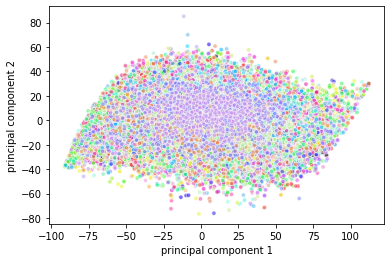

In [92]:
# 2D visualization of the first two principle components
# each class is given a random colour 
g = sns.scatterplot(x="principal component 1", 
                    y="principal component 2", 
                    hue="label",
                    alpha=0.6,
              data=principalDf, palette=cmap, 
                    size = [0.001 for i in range(118475)], 
                   legend = None)

In [125]:
# identify the first 100 components of X_train_normalized 
pca_100 = PCA(n_components=100)
principalComponents_100 = pca_100.fit_transform(X_train_normalized)

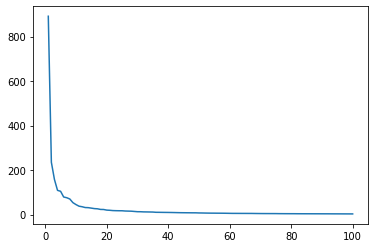

In [129]:
# plot the variance explained by those components 
plt.plot(range(1,101), pca_100.explained_variance_)
plt.show()

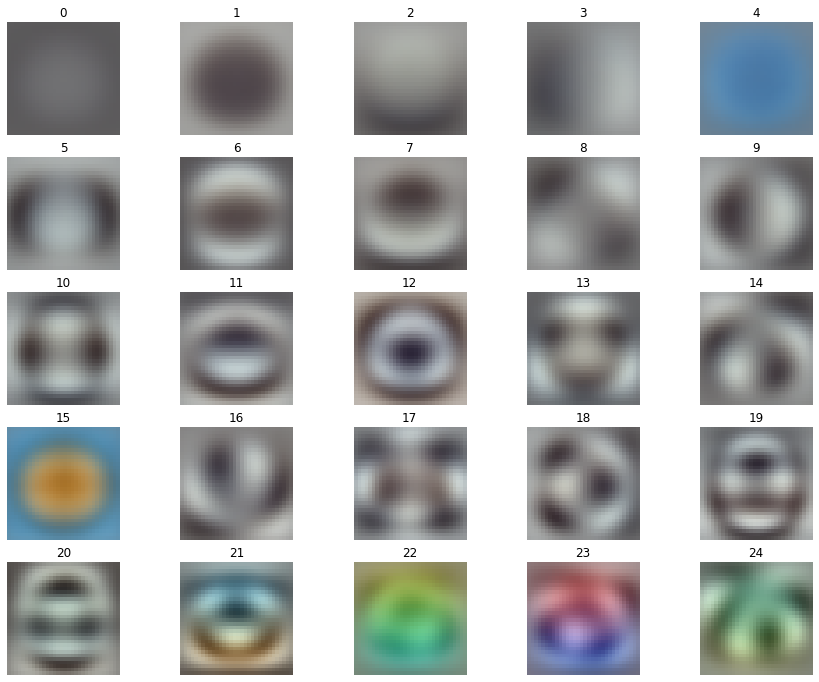

In [137]:
n = 25

# Visualizing first n eigenvectors as images using the previous technique
minimum = np.min(pca_100.components_)
maximum = np.max(pca_100.components_)
images = []
for i in range(n):
    images.append(unroll(pca_100.components_[i],minimum, maximum))

fig= plt.figure(figsize=(15,12))
for i in range(n):
    plt.subplot(5, 5, i + 1) # visulaize the images in a 5 by 5 grid layout 
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
    plt.title(i)

## UMAP 

Since linear dimension reduction techniques did not achieve the desired result, we decided to try a nonlinear technique and see if there are any observable differences. 

In [102]:
import umap.umap_ as umap # wow, amazing

# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# Reduce each vector in X_train to 2D using a nonlinear method
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train)
embedding.shape

(118475, 2)

In [103]:
y_train.shape

(118475,)

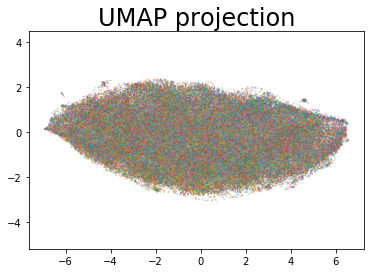

In [121]:
# plot the 2D embedding 
# giving each class a random colour
plt.scatter(embedding[:, 0], embedding[:, 1], c=cmap2, alpha=0.6, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

## Training Neural Network

The first CNN we employed was a basic 7-layer CNN. We have 3 blocks of CONV-RELU-POOL layers and then followed by a dense layer and softmax activation.

In [59]:
# load images and resize to 128 x 128
img_dim = (128,128)
XX_train, yy_train, _ = data_utils.load_train(dim=img_dim)
XX_val, yy_val, _ = data_utils.load_val(dim=im_dim)

In [60]:
XX_val.shape

(11994, 49152)

In [11]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [74]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# edit to change batch size and the number of training epochs
batch_size = 64
epochs = 20

# identify the number of unique classes in the validation data 
num_classes = len(np.unique(yy_val)) 
print(num_classes)

251


In [68]:
from sklearn.model_selection import train_test_split

# convert XX_val to the flattened vectors back to images
# for testing purposes, we trained on the validation set first 
XX = XX_val.reshape((11994,128,128,3))
yy = to_categorical(yy_val)

# split the validation set into training, validation and testing compoents 
# at ratio 0.6, 0.2, 0.2 of the original 
X_train,X_,y_train,y_ = train_test_split(XX, yy, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=13)

In [69]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7196, 128, 128, 3)
(2399, 128, 128, 3)
(2399, 128, 128, 3)


In [70]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7196, 251)
(2399, 251)
(2399, 251)


In [82]:
batch_size = 16
epochs = 5

# create a convoluted neural network using Keras 
model = Sequential() 
model.add(Conv2D(128, kernel_size=(3, 3),activation='linear',
                 input_shape=(128,128,3),padding='same'))
model.add(LeakyReLU(alpha=0))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0))                  
model.add(Dense(num_classes, activation='softmax'))

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 256)      

In [84]:
# compile model with categorical crossentropy as loss 
# gradient descent with ADAM algorith
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# train on X_train, y_train with X_val, y_val as validation set  
model_train = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,verbose=1,
                        validation_data=(X_val, y_val))

Train on 7196 samples, validate on 2399 samples
Epoch 1/5
7196/7196 [==============================] - 786s 109ms/step - loss: 5.5245 - accuracy: 0.0040 - val_loss: 5.5204 - val_accuracy: 0.0033
Epoch 2/5
7196/7196 [==============================] - 761s 106ms/step - loss: 5.5101 - accuracy: 0.0046 - val_loss: 5.5202 - val_accuracy: 0.0033
Epoch 3/5
7196/7196 [==============================] - 760s 106ms/step - loss: 5.5021 - accuracy: 0.0042 - val_loss: 5.5232 - val_accuracy: 0.0033
Epoch 4/5
7196/7196 [==============================] - 1707s 237ms/step - loss: 5.4993 - accuracy: 0.0050 - val_loss: 5.5258 - val_accuracy: 0.0038
Epoch 5/5
7196/7196 [==============================] - 770s 107ms/step - loss: 5.4986 - accuracy: 0.0056 - val_loss: 5.5253 - val_accuracy: 0.0038


In [57]:
# print the final accuaracy and loss 
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 8.114024755407145
Test accuracy: 0.037515632808208466


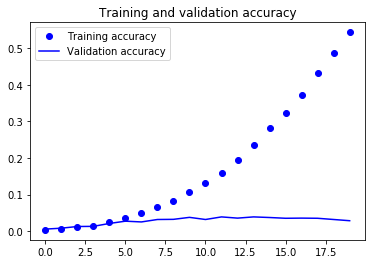

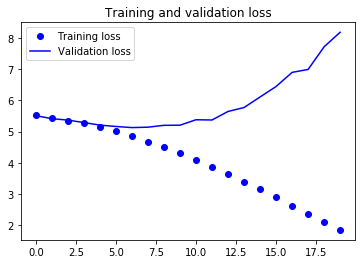

In [58]:
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs_ = range(len(accuracy))

# plot training and and validation accuracy 
plt.plot(epochs_, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot training and validation loss
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [54]:
print(X_val.shape, y_val.shape)

(2399, 32, 32, 3) (2399, 251)


## Training ResNet 

We expanded from the preliminary model by using the ResNet architecture with 50 layers, the full data set, and 64 by 64 images instead of 32 by 32. This was trained with a batch size of 16 for 20 epochs.

In [89]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K

In [90]:
# load resnet with num_classes = 251
resnet = ResNet50(classes=num_classes)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 256)      

In [92]:
# edit to change the number of training epochs and batch size 
epochs = 5 
batch_size = 16

# compile the model with your choice of loss function and optimizer
resnet.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# train the model using X_train, y_train and validate on X_val and y_val
resnet_train = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,verbose=1,
                        validation_data=(X_val, y_val))

Train on 7196 samples, validate on 2399 samples
Epoch 1/5
7196/7196 [==============================] - 899s 125ms/step - loss: 5.4977 - accuracy: 0.0047 - val_loss: 5.5270 - val_accuracy: 0.0046
Epoch 2/5
7196/7196 [==============================] - 2011s 279ms/step - loss: 5.4975 - accuracy: 0.0051 - val_loss: 5.5254 - val_accuracy: 0.0046
Epoch 3/5
7196/7196 [==============================] - 795s 110ms/step - loss: 5.4973 - accuracy: 0.0053 - val_loss: 5.5261 - val_accuracy: 0.0038
Epoch 4/5
7196/7196 [==============================] - 808s 112ms/step - loss: 5.4968 - accuracy: 0.0051 - val_loss: 5.5248 - val_accuracy: 0.0046
Epoch 5/5
7196/7196 [==============================] - 789s 110ms/step - loss: 5.4966 - accuracy: 0.0044 - val_loss: 5.5254 - val_accuracy: 0.0046


In [106]:
XX_train, yy_train, _ = data_utils.load_train(dim=(64,64))
XX_val, yy_val, _ = data_utils.load_val(dim=(64,64))

In [107]:
print(XX_train.shape, yy_train.shape)
print(XX_val.shape, yy_val.shape)

(118475, 12288) (118475,)
(11994, 12288) (11994,)


In [111]:
# convert each row into (64,64,3) image vectors 
X_train = XX_train.reshape((XX_train.shape[0], 64, 64, 3))
X_val = XX_val.reshape((XX_val.shape[0], 64, 64, 3))

In [110]:
XX_train.shape[0]

118475

In [112]:
# convert the group labels to a one hot encoding 
y_train = to_categorical(yy_train)
y_val = to_categorical(yy_val)

In [113]:
print(X_train.shape, 
      y_train.shape, 
      X_val.shape, 
      y_val.shape)

(118475, 64, 64, 3) (118475, 251) (11994, 64, 64, 3) (11994, 251)


In [123]:
# edit this to change the batch size and number of trainign epochs 
batch_size = 16
epochs = 20

resnet = ResNet50(input_shape = (64, 64, 3), classes=num_classes)

In [124]:
resnet.compile(loss=keras.losses.categorical_crossentropy, 
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'])

# train a neuralnet with resnet architecture 
resnet_train = resnet.fit(X_train, 
                         y_train, 
                         batch_size=batch_size, 
                         epochs=epochs,
                         verbose=1,
                         validation_data=(X_val, y_val))

Train on 118475 samples, validate on 11994 samples
Epoch 1/20
118475/118475 [==============================] - 8037s 68ms/step - loss: 5.4200 - accuracy: 0.0138 - val_loss: 237.2974 - val_accuracy: 0.0097
Epoch 2/20
118475/118475 [==============================] - 20171s 170ms/step - loss: 5.0054 - accuracy: 0.0368 - val_loss: 5.3379 - val_accuracy: 0.0318
Epoch 3/20
118475/118475 [==============================] - 28188s 238ms/step - loss: 4.6829 - accuracy: 0.0665 - val_loss: 4.5311 - val_accuracy: 0.0816
Epoch 4/20
118475/118475 [==============================] - 9234s 78ms/step - loss: 4.4111 - accuracy: 0.0964 - val_loss: 4.4715 - val_accuracy: 0.0870
Epoch 5/20
118475/118475 [==============================] - 8530s 72ms/step - loss: 4.2227 - accuracy: 0.1195 - val_loss: 4.7015 - val_accuracy: 0.0764
Epoch 6/20
118475/118475 [==============================] - 8533s 72ms/step - loss: 4.0429 - accuracy: 0.1440 - val_loss: 3.9666 - val_accuracy: 0.1528
Epoch 7/20
118475/118475 [=====

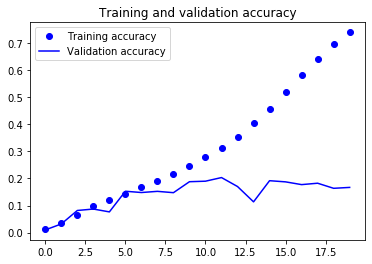

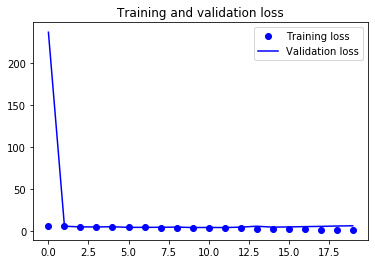

In [125]:
accuracy = resnet_train.history['accuracy']
val_accuracy = resnet_train.history['val_accuracy']
loss = resnet_train.history['loss']
val_loss = resnet_train.history['val_loss']
epochs_ = range(len(accuracy))

# plot accuracy 
plt.plot(epochs_, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot loss 
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [126]:
# save with the following name 
model_name = "resnet50_epoch20_batch16.h5"
resnet.save(model_name)

## Submission

In [2]:
from numpy import loadtxt
from keras.models import load_model

# load model from path
model = load_model('resnet50_epoch20_batch16.h5')

Using TensorFlow backend.


In [3]:
import _pickle as pickle
import numpy as np
import os
import pandas as pd 
from skimage.io import ImageCollection, imshow, concatenate_images
from skimage.transform import resize

def load_images(im_dir, dim=(128,128)):
    """load images into 2D array 
    --------------
    im_dir: the folder where the images are found 
    dim: the size that the images are resized to
    """
    images = ImageCollection(im_dir)
    images_resized = [resize(image, dim) for image in images]
    num_images = len(images_resized)
    image_arr = np.reshape(concatenate_images(images_resized), (num_images, -1))
    return image_arr

# im_dir is the location of the test set + "/*.jpg"
im_dir = "/Users/kenzeng/Desktop/College/COMP/COMP540/Project/ifood-2019-fgvc6/test_set/*.jpg"
test_img = load_images(im_dir)

In [4]:
results = model.predict(test_img.reshape(test_img.shape[0], 128, 128,3))

In [5]:
results.shape

(28377, 251)

In [14]:
# open the submission file 
submission = pd.read_csv("/Users/kenzeng/Desktop/College/COMP/COMP540/Project/ifood-2019-fgvc6/sample_submission.csv")

# order the labels by the output values 
sorted_labels = np.argsort(results, axis=1)

# identify labels with the top 3 outputs and store in submission dataframe 
submission["0"] = np.apply_along_axis(lambda x: x[0], 1, sorted_labels) 
submission["1"] = np.apply_along_axis(lambda x: x[1], 1, sorted_labels)
submission["2"] = np.apply_along_axis(lambda x: x[2], 1, sorted_labels)
submission

,img_name,label,0,1,2
0,test_024088.jpg,250,162,172,89
1,test_024089.jpg,250,89,203,161
2,test_024090.jpg,250,162,245,56
3,test_024091.jpg,250,162,89,236
4,test_024092.jpg,250,162,245,153
...,...,...,...,...,...
28372,test_024083.jpg,250,162,89,68
28373,test_024084.jpg,250,162,89,110
28374,test_024085.jpg,250,183,66,89
28375,test_024086.jpg,250,162,131,68


In [20]:
# concatenate the three columns into a single column to fit submission format
cols = ["0", "1", "2"]
submission["label"] = submission[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# save test submission as a csv 
submission[["img_name", "label"]].to_csv('submission.csv', index=False)
submission.describe()

,0,1,2
count,28377.000000,28377.000000,28377.000000
mean,135.512915,113.761849,116.610494
std,47.124091,60.422931,64.599328
min,0.000000,0.000000,0.000000
25%,89.000000,68.000000,68.000000
50%,162.000000,94.000000,103.000000
75%,162.000000,162.000000,162.000000
max,250.000000,250.000000,250.000000
